# Project 1: Image Classification

## Task 0: Getting Started

Read the getting started guide titled **"Python for Deep Learning"** and get familiar with Python and PyTorch. Read the provided code below and get familiar with the commands and their parameters to understand what the code is trying to do. We recommend to spend a fair amount of time to understand all the different parts of the code. This understanding will be important for this and future projects.

The goal of this project is to implement the *“Hello World!”* program of deep learning: designing and training a network that performs image classification. The dataset we will be using is CIFAR10 which is a large set of images that are classified into 10 classes (airplane, bird, cat, etc.).

## Task 1:  Data Loading (10 points)
Complete the **DataLoader** below which we will use to load images of the cifar10 dataset provided by torchvision. Your task is to normalize it by shifting and scaling it by a factor of 0.5. For the training set, introduce random transformations (e.g. flips) for data augmentation.

In [ ]:
from __future__ import print_function, division

import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
print(torch.__version__)
from PIL import Image
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

# Data augmentation, tensor conversion and normalization for training
# Just normalization and tensor conversion for testing
mean, std = (0.5,), (0.5,)
data_transforms = {
    'train': transforms.Compose([transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize(mean, std)]),
    'test': transforms.Compose([transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean, std)])
}

# Download (if not downloaded before) & Load CIFAR10
torch.random.manual_seed(0)
image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=(x=='train'), download=True, transform=data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=(x=='train'), num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# Ship to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(f"The classes found in CIFAR-10 are: {class_names}")

### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations. The results should look like:

<img src="https://i.imgur.com/Sa6l1go.png" width="400" align="left">

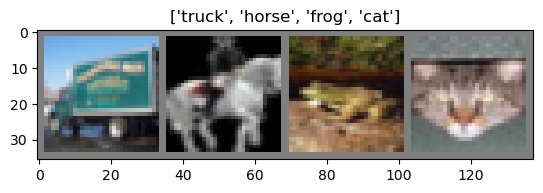

In [8]:
# TODO Task 1:  Run this cell and try to understand the output of each step
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Task 2: Basic Networks (20 points)
1. Create a Fully connected Network (FcNet) using the following layers in the Jupyter Notebook (use the non-linearities wherever necessary):
```
FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the FcNet for **3** epoches and record the training time and accuracy in your final report.

2. Create a Convolutional Network (ConvNet) using the following layers in the Jupyter Notebook (use the non-linearities wherever necessary):
```
ConvNet(
  (conv): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the ConvNet for **3** epoches and record the training time and accuracy in your final report. Note: You can reuse the conv layers to match the in_features of fc1. 

*Use the default SGD optimizer ( lr=0.001, momentum=0.9) for training.

### Model training code 

In [9]:
def train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth'):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train': model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), save_path)
    return model

### Model test code 

In [10]:
def test_model(model, load_path='saved_weight.pth'):    
    # load the model weights
    model.load_state_dict(torch.load(load_path))
    
    since = time.time()

    for phase in ['test']:
        if phase == 'test':
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
           

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Acc: {:.4f}'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return 

### 1) FC Network

In [ ]:
# 1) Define a Fully Connected Neural Network
# Please advise the Pytorch Documentation and use the appropiate calls

class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        # TODO Task 2:  Define the layers 
        self.fc1 = nn.Linear(in_features=3072, out_features=1024, bias=True)
        self.fc2 = nn.Linear(in_features=1024, out_features=400, bias=True)
        self.fc3 = nn.Linear(in_features=400, out_features=84, bias=True)
        self.fc4 = nn.Linear(in_features=84, out_features=10, bias=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        # TODO Task 2:  Define the forward pass
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model_ft = FcNet() #Define the model
model_ft = model_ft.to(device) 
print(model_ft)

# TODO Task 2:  Define loss criterion - cross entropy loss
criterion = F.cross_entropy

# TODO Task 2:  Define Optimizer
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# TODO Task 2:  Train the model
model_train = train_model(model_ft, criterion, optimizer, num_epochs=3, save_path='saved_FcNet_weight.pth')

# TODO Task 2:  Test the model
model_test = test_model(model_ft, load_path='saved_FcNet_weight.pth')

FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)
Epoch 0/2
----------


### 2) CNN

In [ ]:
# 2) Define a Convolutional Neural Network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # TODO Task 2:  Define the CNN layers 
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
        self.fc1 = nn.Linear(in_features=400, out_features=120, bias=True)
        self.fc2 = nn.Linear(in_features=120, out_features=84, bias=True)
        self.fc3 = nn.Linear(in_features=84, out_features=10, bias=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        # TODO Task 2:  Define the forward pass
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 400)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = ConvNet() #Define the model
model_ft = model_ft.to(device)
print(model_ft)

# TODO Task 2:  Define loss criterion - cross entropy loss
criterion = F.cross_entropy

# TODO Task 2:  Define Optimizer
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# TODO Task 2:  Train the model
model_train = train_model(model_ft, criterion, optimizer, num_epochs=3, save_path='saved_CNNNet_weight.pth')

# TODO Task 2:  Test the model
model_test = test_model(model_ft, load_path='saved_CNNNet_weight.pth')

## Task 3.A: Design Your Network (30 points)
Define your own Convolutional Network (MyNet) based on the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) architecture (see Sec. 4.2 for the original architecture used). Here we will experiment with different configurations. Add following modifications and train the Network for **25** epoches. Keep the best settings for each step (for each step, record the training accuracy of the last epoch and test accuracy in your report):

- Modify the number of ResNet blocks per layer: For Simplicity, implement a three-layered ResNet architecture. For each layer, try 1 , 2 and 3 number of ResNet blocks (3 configurations in total). You can choose any of the downsampling methods to match the tensor sizes wherever necessary. Use 2D average pooling layer before applying the final linear layer. For the three layers keep the number of filters 16, 32 and 64 respectively. Follow the ResNet paper to select the kernel size, paddings, optimizer/learning rate, strides, activations and **Batch Normalization** (select a suitable batch size) layers for this task. Print the model summary of the selected model.

#### *Bonus Points: Define a validation set within the training set to monitor underfitting/overfitting after every epoch for each task. (Hint modify dataloaders and/or train_model function) 

### Design Your Network

In [9]:
# Task 3.A: Configuration 1

class MyNet(nn.Module):
    def __init__(self, num_block=3):
        super(MyNet, self).__init__()
        # TODO Task 3: Design Your Network
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.layer1 = ResNetBlock(16, 16)
        self.layer2 = ResNetBlock(16, 32, stride=2)
        self.layer3 = ResNetBlock(32, 64, stride=2)
        if num_block>1:
            self.layer1 = nn.Sequential(self.layer1,ResNetBlock(16, 16))
            self.layer2 = nn.Sequential(self.layer2,ResNetBlock(32, 32))
            self.layer3 = nn.Sequential(self.layer3,ResNetBlock(64, 64))
        if num_block>2:
            self.layer1 = nn.Sequential(self.layer1,ResNetBlock(16, 16))
            self.layer2 = nn.Sequential(self.layer2,ResNetBlock(32, 32))
            self.layer3 = nn.Sequential(self.layer3,ResNetBlock(64, 64))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # TODO Task 3: Design Your Network
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

In [10]:
# Task 3.A: Configuration 2

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                                          nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


In [11]:
# Task 3.A: Configuration 3

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()

for i in range(3):
    model = MyNet(num_block=i+1).to(device) ## choose num_block=1,2,3

    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

    model_train = train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_ResNet_Block'+str(i+1)+'_weight.pth')
    model_test = test_model(model, load_path='saved_ResNet_Block'+str(i+1)+'_weight.pth')

Files already downloaded and verified
Files already downloaded and verified
Epoch 0/24
----------
train Loss: 1.9865 Acc: 0.2707
Epoch 1/24
----------
train Loss: 1.8384 Acc: 0.3171
Epoch 2/24
----------
train Loss: 1.7586 Acc: 0.3548
Epoch 3/24
----------
train Loss: 1.7311 Acc: 0.3666
Epoch 4/24
----------
train Loss: 1.7097 Acc: 0.3779
Epoch 5/24
----------
train Loss: 1.7060 Acc: 0.3828
Epoch 6/24
----------
train Loss: 1.6997 Acc: 0.3845
Epoch 7/24
----------
train Loss: 1.7071 Acc: 0.3778
Epoch 8/24
----------
train Loss: 1.7029 Acc: 0.3832
Epoch 9/24
----------
train Loss: 1.7021 Acc: 0.3845
Epoch 10/24
----------
train Loss: 1.7079 Acc: 0.3803
Epoch 11/24
----------
train Loss: 1.7028 Acc: 0.3854
Epoch 12/24
----------
train Loss: 1.7078 Acc: 0.3796
Epoch 13/24
----------
train Loss: 1.7199 Acc: 0.3750
Epoch 14/24
----------
train Loss: 1.7184 Acc: 0.3757
Epoch 15/24
----------
train Loss: 1.7274 Acc: 0.3738
Epoch 16/24
----------
train Loss: 1.7347 Acc: 0.3714
Epoch 17/24
----

## Task 3.B: Design Your Network (10 points)
Using your best network/model from Task 3.A, please do the following modifications:

- Use Dropout: Toggle **Dropout** in fully connected layers. Does it improve the validation/test accuracy and/or avoid overfitting?

In [ ]:
# Task 3.B: Using Dropout
class MyNet(nn.Module):
    def __init__(self, num_block=3, dropout_rate=0.5): ##dropout_rate is newly added
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.layer1 = ResNetBlock(16, 16)
        self.layer2 = ResNetBlock(16, 32, stride=2)
        self.layer3 = ResNetBlock(32, 64, stride=2)
        
        if num_block==2:
            self.layer1 = nn.Sequential(self.layer1,ResNetBlock(16, 16))
            self.layer2 = nn.Sequential(self.layer2,ResNetBlock(32, 32))
            self.layer3 = nn.Sequential(self.layer3,ResNetBlock(64, 64))
            
        elif num_block==3:
            self.layer1 = nn.Sequential(self.layer1,ResNetBlock(16, 16),ResNetBlock(16, 16))
            self.layer2 = nn.Sequential(self.layer2,ResNetBlock(32, 32),ResNetBlock(32, 32))
            self.layer3 = nn.Sequential(self.layer3,ResNetBlock(64, 64),ResNetBlock(64, 64))
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate) ##newly added
        
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out) ##newly added
        out = self.fc(out)
        return out

model = MyNet(num_block=3, dropout_rate=0.5).to(device) ##newly changed

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
model_train = train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_Droupout_weight.pth')
model_test = test_model(model, load_path='saved_Droupout_weight.pth')

Epoch 0/24
----------
train Loss: 2.3686 Acc: 0.1001
Epoch 1/24
----------
train Loss: 2.3586 Acc: 0.1002
Epoch 2/24
----------
train Loss: 2.3601 Acc: 0.0978
Epoch 3/24
----------
train Loss: 2.3603 Acc: 0.0994
Epoch 4/24
----------
train Loss: 2.3583 Acc: 0.1003
Epoch 5/24
----------
train Loss: 2.3592 Acc: 0.0991
Epoch 6/24
----------


## Task 4: The Optimizer (20 points)
Keeping the best settings of Task 4, try 2 different optimizers (SGD and ADAM) with 3 different learning rates (0.01, 0.1, 1.) . Keep the other parameters as default. Plot the loss curves ( Training step vs Training loss ) for the 6 cases (Hint: Modify the train_model fuction). How does the learning rate affect the training?

#### *Bonus Points: Define a validation set within the training set to examine the best model among the above cases. (Hint modify dataloaders and/or train_model function) 

In [11]:
# Define a Convolutional Neural Network
class MyFinalNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # TODO Task 3: Design Your Network

    def forward(self, x):
        # TODO Task 3: Design Your Network
        return x

In [12]:
model = MyFinalNet() ##TODO
model = model.to(device)

# TODO:  Define loss criterion - cross entropy loss
criterion = F.cross_entropy

# TODO Task 4: The Optimizer
def configure_optimizers(model, name='SGD', rate=0.01):
    if name=='SGD':
        optimizer = optim.SGD(model.parameters(), lr=rate, momentum=0.9, weight_decay=5e-4)
    elif name=='ADAM'
        optimizer = optim.AdamW(model.parameters(), lr=rate, weight_decay=5e-4)
    return optimizer


## Train and evaluate
def train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs=25):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0
        model.train()
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_loss /= len(train_loader.dataset)
            train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                test_loss /= len(test_loader.dataset)
                test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

    return train_losses, test_losses

rates = [0.01, 0.1, 1.0]

for lr in rates:
    "SGD optimizer with learning rates of 0.01, 0.1, and 1.0"
    optimizer = configure_optimizers(model, name='SGD', rate=lr)
    train_losses, test_losses = train_model(model, optimizer, criterion, train_loader, test_loader)
    plt.plot(train_losses, label=f"SGD lr={lr}")

for lr in rates:
    "ADAM optimizer with learning rates of 0.01, 0.1, and 1.0"
    optimizer = configure_optimizers(model, name='ADAM', rate=lr)
    train_losses, test_losses = train_model(model, optimizer, criterion, train_loader, test_loader)
    plt.plot(train_losses, label=f"ADAM lr={lr}")

plt.legend()
plt.title("Training Loss vs. Training Step")
plt.xlabel("Training Step")
plt.ylabel("Training Loss")
plt.show()

### Display model predictions

In [13]:
## Display model predictions
## Generic function to display predictions for a few images

def display_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
# TODO Diplay your best model predictions
model = MyFinalNet() ##TODO
model = model.to(device)
display_predictions(model, num_images=10)

## Task 5: Feature Visualization (5 points)
Visualize feature maps of the first and the last convolutional layer of your final network using **cifar_example.jpg** as input image. Show the visualization in the report.

#### First layer activations
<img src="https://i.imgur.com/kGB9AuP.png" width="400" align="left">

#### Last layer activations

<img src="https://i.imgur.com/qelH05X.png" width="400" align="left">

In [15]:
#Task 5: Visualization

In [ ]:
def transfer_single_img_to_tensor(img_path):
    im = Image.open(img_path)
    img = np.asarray(im)/255
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    inp = (img - mean) / std
    inp = np.asarray(inp, dtype=np.float32)
    inp = inp.transpose((2, 0, 1))
    inp = np.expand_dims(inp, axis=0)
    inp = torch.from_numpy(inp, )
    inputs = inp.to(device)
    return inputs

In [ ]:
def feature_imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
inputs = transfer_single_img_to_tensor('example_imgs/cifar_example.jpg') # Loads an image and normalizes it
model.eval()
with torch.no_grad():
   # TODO: Retrive the first and the last layer feature maps of your best model. (Hint: Move back to CPU)
    
    # Load the best model
    best_model = torch.load("best_model.pth")

#     def get_feature_maps(model, input):
#         # Define empty lists to store the feature maps
#         first_layer_maps = []
#         last_layer_maps = []

#         # Define the hooks for the first and last layers
#         def first_layer_hook(module, input, output):
#             first_layer_maps.append(output.detach().cpu())
#         def last_layer_hook(module, input, output):
#             last_layer_maps.append(output.detach().cpu())

#         # Register the hooks
#         model.conv1.register_forward_hook(first_layer_hook)
#         model.fc3.register_forward_hook(last_layer_hook)

#         # Run the model on the input
#         model.eval()
#         with torch.no_grad():
#             model(input)

#         # Remove the hooks
#         model.conv1.unregister_forward_hook(first_layer_hook)
#         model.fc3.unregister_forward_hook(last_layer_hook)

#         # Return the feature maps
#         return first_layer_maps1, last_layer_maps1

    # Get the feature maps
    first_layer_maps, last_layer_maps = get_feature_maps(best_model, input) ##HUI TODO
    

In [ ]:
# Visualize the feature maps
out = torchvision.utils.make_grid(first_layer_maps, normalize=True, scale_each=True)
feature_imshow(out)

In [ ]:
out = torchvision.utils.make_grid(last_layer_maps, normalize=True, scale_each=True)
feature_imshow(out)

In [30]:
import torch
c_hidden=[16,32,64]
for block_idx, block_count in enumerate([1,1,1]):
    print('--',block_idx, block_count)
    for bc in range(block_count):
        subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
        print(subsample)
        c_in=c_hidden[block_idx if not subsample else (block_idx-1)]
        c_out=c_hidden[block_idx]
        print(c_in, c_out)
import numpy as np
dims=[100]*7
for din, dout in zip(dims[:-1], dims[1:]):
    w=np.random.randn(din,dout)/np.sqrt(din)
    print(w)

-- 0 1
False
16 16
-- 1 1
True
16 32
-- 2 1
True
32 64
[[ 0.03614257 -0.11447922 -0.00608285 ...  0.09562786 -0.05837232
   0.00630627]
 [ 0.03315374 -0.03426623  0.05281999 ...  0.04018801  0.0363416
   0.0021361 ]
 [-0.06088167  0.08568906 -0.05251234 ... -0.14975338  0.18463183
  -0.02893766]
 ...
 [-0.20379863  0.19193744  0.18737518 ... -0.18271653 -0.21279135
  -0.19107082]
 [ 0.03579932 -0.0971399  -0.07980046 ... -0.03927716 -0.00694625
  -0.09953044]
 [-0.03674747 -0.05493688 -0.2050911  ...  0.04234331  0.0307241
   0.02567111]]
[[ 0.02746231 -0.16358249  0.05600756 ...  0.11009977  0.01260974
   0.11766019]
 [ 0.0060675  -0.00405898  0.04668303 ... -0.07084221 -0.00099888
  -0.02177241]
 [-0.0760075   0.0621215  -0.15747666 ...  0.06615362  0.0131195
   0.15038898]
 ...
 [-0.2369792   0.09459271  0.04741216 ... -0.0082923   0.1809585
  -0.01551003]
 [-0.05940694  0.01231841  0.11214063 ...  0.07280646 -0.08228176
   0.03651057]
 [ 0.11017407 -0.0932294   0.17555126 ...  0.05

## Task 6: Weight Visualization (5 points)
Visualize weights of convolutional layers of your final network. Show the visualization in the report.

In [ ]:
# TODO: Task 6
# Hint: 
# 1) What is the size of each weight (filter) tensor?
# 2) Normalize weight values to [0, 1]
# 3) Each subfigure should be of size [kernel_size, kernel_size]
# 4) How many subfigures in total?

# Get the convolutional layers
# conv_layers = 1 ##HUITODO

# # Plot the weights of each convolutional layer
# for i, layer in enumerate(conv_layers):
#     weights = layer.weight.data
#     num_kernel = weights.shape2 * weights.shape3
#     fig, axs = plt.subplots(weights.shape2, weights.shape3, figsize=(kernel_size, kernel_size))
#     for j in range(weights.shape2):
#         for k in range(weights.shape3):
#             # Normalize the weight values to 4
#             weight = weights5.cpu().numpy()
#             weight = (weight - weight.min()) / (weight.max() - weight.min())
#             axs5.imshow(weight, cmap="gray")
#     axs5.axis("off")
#     fig.suptitle(f"Convolutional Layer {i+1}")
#     plt.show()



import math
import seaborn as sns

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

def normalize_weights(conv_layer):
    "Normalize the weights"
    weights = conv_layer.weight.data
    min_val = weights.min().item()
    max_val = weights.max().item()
    weights = (weights - min_val) / (max_val - min_val)
    return weights

def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            #a = param.detach().numpy().shape[1]
            a = 3
            param.data.normal_(std=1.0/math.sqrt(a)) ##param.shape[1]

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()


equal_var_init(best_model)
visualize_weight_distribution(best_model)